## Driver code comparing output of different atlas / parcellations 

### Steps
- import data csvs from different atlases
- compare performance of machine-learning model (scikit-learn)
- compare performance of statsmodels (ols or logit)

In [1]:
import sys
import numpy as np
import pandas as pd
import itertools

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from matplotlib_venn import venn2, venn3

import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time

sys.path.append('../')
from lib.data_handling import *
from lib.data_stats import *

### Data paths

In [2]:
proj_dir = '/home/nikhil/projects/CT_reproduce/code/compare-surf-tools/'
data_dir = proj_dir + 'data/'
results_dir = data_dir + 'results/'
qc_dir =  '/home/nikhil/projects/CT_reproduce/data/QC/'
outlier_dir = data_dir + 'outliers/'
fs60_dir = data_dir + 'fs60_group_stats/'
demograph_file = 'ABIDE_Phenotype.csv'

#fs60 all files
# Thickness
fs60_aparc_lh_thickness_file = 'lh.aparc.thickness.table.test1'
fs60_aparc_rh_thickness_file = 'rh.aparc.thickness.table.test1' #34 ROIs
fs60_aparc2009_lh_thickness_file = 'lh.aparc.a2009.thickness.table.test1' #74 ROIs per hemi
fs60_aparc2009_rh_thickness_file = 'rh.aparc.a2009.thickness.table.test1'
fs60_glasser_lh_thickness_file = 'lh.glasser.thickness.table.test1' #180 ROIs per hemi
fs60_glasser_rh_thickness_file = 'rh.glasser.thickness.table.test1'

#outlier files
aparc_outlier_file = 'aparc_outlier_data.csv'
destr_outlier_file = 'des_outlier_data.csv'
glass_outlier_file = 'glas_outlier_data.csv'

### Global Vars

In [3]:
subject_ID_col = 'SubjID'

### Load data

In [4]:
# Demographics and Dx
demograph = pd.read_csv(data_dir + demograph_file)
demograph = demograph.rename(columns={'Subject_ID':subject_ID_col})

# aparc
aparc = 'aparc'
fs60_aparc_lh_thickness_data = pd.read_csv(fs60_dir + fs60_aparc_lh_thickness_file, delim_whitespace=True)
fs60_aparc_rh_thickness_data = pd.read_csv(fs60_dir + fs60_aparc_rh_thickness_file, delim_whitespace=True)
print('shape of fs60 aparc data l: {}, r: {}'.format(fs60_aparc_lh_thickness_data.shape,fs60_aparc_rh_thickness_data.shape))
fs60_aparc_thickness_data_std = standardize_fs60_data(fs60_aparc_lh_thickness_data, 
                                                      fs60_aparc_rh_thickness_data, subject_ID_col, aparc)
print('shape of stdized fs60 aparc data {}'.format(fs60_aparc_thickness_data_std.shape))


# Destrieux
aparc = 'aparc.a2009s'
fs60_aparc2009_lh_thickness_data = pd.read_csv(fs60_dir + fs60_aparc2009_lh_thickness_file, delim_whitespace=True)
fs60_aparc2009_rh_thickness_data = pd.read_csv(fs60_dir + fs60_aparc2009_rh_thickness_file, delim_whitespace=True)
print('shape of fs60 aparc2009 data l: {}, r: {}'.format(fs60_aparc2009_lh_thickness_data.shape,fs60_aparc2009_rh_thickness_data.shape))
fs60_aparc2009_thickness_data_std = standardize_fs60_data(fs60_aparc2009_lh_thickness_data,
                                                          fs60_aparc2009_rh_thickness_data, subject_ID_col, aparc)
print('shape of stdized fs60 aparc data {}'.format(fs60_aparc2009_thickness_data_std.shape))


# Glasser
aparc = 'aparc.Glasseratlas'
fs60_glasser_lh_thickness_data = pd.read_csv(fs60_dir + fs60_glasser_lh_thickness_file, delim_whitespace=True)
fs60_glasser_rh_thickness_data = pd.read_csv(fs60_dir + fs60_glasser_rh_thickness_file, delim_whitespace=True)
print('shape of fs60 glasser data l: {}, r: {}'.format(fs60_glasser_lh_thickness_data.shape,fs60_glasser_rh_thickness_data.shape))
fs60_glasser_thickness_data_std = standardize_fs60_data(fs60_glasser_lh_thickness_data,
                                                          fs60_glasser_rh_thickness_data, subject_ID_col, aparc)
print('shape of stdized fs60 aparc data {}'.format(fs60_glasser_thickness_data_std.shape))

n_workflow = 1 #Analyzing each atlas separately

shape of fs60 aparc data l: (1047, 36), r: (1047, 36)
shape of left and right merge fs6.0 df (1047, 71)
shape of stdized fs60 aparc data (1047, 71)
shape of fs60 aparc2009 data l: (1047, 76), r: (1047, 76)
shape of left and right merge fs6.0 df (1047, 151)
shape of stdized fs60 aparc data (1047, 151)
shape of fs60 glasser data l: (1047, 182), r: (1047, 182)
shape of left and right merge fs6.0 df (1047, 363)
shape of stdized fs60 aparc data (1047, 363)


### Create master dataframe

In [5]:
data_dict = {'aparc' : fs60_aparc_thickness_data_std,
            'Destrieux' : fs60_aparc2009_thickness_data_std,
            'Glasser' : fs60_glasser_thickness_data_std}

outlier_file_dict = {'aparc' : aparc_outlier_file,
            'Destrieux' : destr_outlier_file,
            'Glasser' : glass_outlier_file}

# Add demographic columns to the master_df
useful_demograph = demograph[[subject_ID_col,'SEX','AGE_AT_SCAN','DX_GROUP','SITE_ID']].copy()

# Replace to (2 with 0 for statsmodels) (1:ASD, 0:Controls)
useful_demograph['DX_GROUP'] = useful_demograph['DX_GROUP'].replace({2:0})
useful_demograph['SEX'] = useful_demograph['SEX']-1

_,useful_demograph[subject_ID_col] = useful_demograph[subject_ID_col].str.rsplit('_', 1).str

### CCA between cortical "representations"
* Should be close to 1 since they are from same pipeline (FS6.0)

In [6]:
from sklearn.cross_decomposition import CCA

n_components = 10
possible_pairs = list(itertools.combinations(data_dict.keys(), 2))

sim_df_concat = pd.DataFrame()
    
qc_list = ['No_QC','manual_maarten','manual_gleb','auto']

for p, pair in enumerate(possible_pairs):
    print('\nAtlas pair {}'.format(pair))
    
    for qc in qc_list:
        for a, atlas in enumerate(pair):
            parc_df = data_dict[atlas]
            
            if qc == 'No_QC':
                print('No QC applied')
                filtered_df = parc_df
                filtered_subs = filtered_df[subject_ID_col].unique()
                print('Resultant number of subjects {}'.format(len(filtered_subs)))
            else:            
                if qc == 'manual_maarten':
                    qc_df = pd.read_csv(qc_dir + 'master_QC_table.csv',dtype={'SubjID': int})
                    qc_criterion = ('QC_maarten',[0]) # keep subs
                elif qc == 'manual_gleb':
                    qc_df = pd.read_csv(qc_dir + 'master_QC_table.csv',dtype={'SubjID': int})
                    qc_criterion = ('QC_gleb',['1','-+1']) # keep subs
                elif qc == 'auto':
                    outlier_file = outlier_file_dict[atlas]
                    qc_df = pd.read_csv(outlier_dir + outlier_file,dtype={'SubjID': int})
                    qc_criterion = ('outlier_all_data',[0])    
                else:
                    print('Unknow QC type')

                # Subjects you want to keep based on other crieria for sample size purposes
                external_criterion = None
                filtered_df = filter_data(parc_df, subject_ID_col, qc_df, qc_criterion, external_criterion)
    
            roi_cols = filtered_df.filter(regex='^L|R_', axis=1).columns
            
            if a==0: 
                X = parc_df[roi_cols].values
            else:
                Y = parc_df[roi_cols].values
    
        print('representation shapes for qc {}, {}:{}, {}:{}'.format(qc, pair[0], X.shape, pair[1], Y.shape))            

        cca = CCA(n_components=n_components,scale=True)
        cca.fit(X, Y)
        X_c, Y_c = cca.transform(X, Y)
        corr_list = []
        for c in range(n_components):
            corr = np.corrcoef(X_c[:,c].flatten(),Y_c[:,c].flatten())[0,1]
            corr_list.append(np.round(corr,3))

        sim_df = pd.DataFrame(columns=['pair','cca_corr','qc_type'])
        sim_df.loc[p] = ['{}_{}'.format(pair[0],pair[1]),np.mean(corr_list),qc]

        sim_df_concat = sim_df_concat.append(sim_df)
        print('{} {} correlation {}'.format(parc1, parc2, np.mean(corr_list)))




Atlas pair ('aparc', 'Glasser')
No QC applied
Resultant number of subjects 1047
No QC applied
Resultant number of subjects 1047
representation shapes for qc No_QC, aparc:(1047, 68), Glasser:(1047, 360)


/home/nikhil/anaconda3/envs/CT_reproduce/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/nikhil/anaconda3/envs/CT_reproduce/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/nikhil/anaconda3/envs/CT_reproduce/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/nikhil/anaconda3/envs/CT_reproduce/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/nikhil/anaconda3/envs/CT_reproduce/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/nikhil/anaconda3/envs/CT_reproduce/lib/python3.5/site-

NameError: name 'parc1' is not defined

In [ ]:
# Plot CCA transform correlations
plot_df = sim_df_concat
sns.set(font_scale=1)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x='cca_corr',y='qc_type',hue='pair',palette='Set1',
                data=plot_df,aspect=2,height=5,kind='strip')

### Compare ML performance 

In [10]:
ml_results_dir = results_dir + 'ml/'
model_type = 'regression'
qc_list = ['No_QC','manual_maarten','manual_gleb','auto']
ml_perf_concat = pd.DataFrame()

cv_type = 'shuffle_split'
feature_rank_df_concat = pd.DataFrame()

perf_pval_dict = {}
start_time_ML = time.time()

for atlas in data_dict.keys():
    start_time_atlas = time.time()
    print('\nAtlas {}'.format(atlas))
    master_df_raw = pd.merge(useful_demograph,data_dict[atlas],on= subject_ID_col)
    
    # For each atlas create a dictionary df
    for qc in qc_list:
        if qc == 'No_QC':
            print('No QC applied')
            filtered_df = master_df_raw
            filtered_subs = filtered_df[subject_ID_col].unique()
            print('Resultant number of subjects {}'.format(len(filtered_subs)))
        else:            
            if qc == 'manual_maarten':
                qc_df = pd.read_csv(qc_dir + 'master_QC_table.csv',dtype={'SubjID': int})
                qc_criterion = ('QC_maarten',[0]) # keep subs
            elif qc == 'manual_gleb':
                qc_df = pd.read_csv(qc_dir + 'master_QC_table.csv',dtype={'SubjID': int})
                qc_criterion = ('QC_gleb',['1','-+1']) # keep subs
            elif qc == 'auto':
                outlier_file = outlier_file_dict[atlas]
                qc_df = pd.read_csv(outlier_dir + outlier_file,dtype={'SubjID': int})
                qc_criterion = ('outlier_all_data',[0])    
            else:
                print('Unknow QC type')

            # Subjects you want to keep based on other crieria for sample size purposes
            external_criterion = {'SITE_ID':3*n_workflow}
            filtered_df = filter_data(master_df_raw, subject_ID_col, qc_df, qc_criterion, external_criterion)
            
        master_df = filtered_df
        roi_cols = list(master_df.filter(regex='^L|R_', axis=1).columns)

        # Need to append Dx based performance separately for now
        # Since using scikit learn defined cross-val-score
        if model_type.lower() == 'regression':
            for dx_grp in [0,1]:
                print('Starting ML models for atlas {} qc {} dx {}'.format(atlas,qc,dx_grp))
                ml_master_df = master_df[master_df['DX_GROUP']==dx_grp]
                outcome_col = 'AGE_AT_SCAN'
                covar_continuous_cols = []
                covar_cat_cols = ['SEX','SITE_ID']
                
                model = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=50)
                ml_perf, null_df, pvalue, feature_rank_df = getMLModelPerf(ml_master_df,roi_cols, 
                                                                           covar_continuous_cols,covar_cat_cols,
                                                                           outcome_col,model_type,model,n_jobs=7)

                ml_perf['atlas'] = np.tile(atlas,len(ml_perf))
                ml_perf['qc'] = np.tile(qc,len(ml_perf))
                ml_perf['DX_GROUP'] = np.tile(dx_grp,len(ml_perf))
                
                null_df['atlas'] = np.tile('null',len(null_df))                
                null_df['qc'] = np.tile(qc,len(null_df))                
                null_df['DX_GROUP'] = np.tile(dx_grp,len(null_df))
                
                ml_perf_concat = ml_perf_concat.append(ml_perf).append(null_df)
                perf_pval_dict[atlas] = pvalue
                
                feature_rank_df['atlas'] = np.tile(atlas,len(feature_rank_df))
                feature_rank_df['DX_GROUP'] = np.tile(dx_grp,len(feature_rank_df))
                feature_rank_df['qc'] = np.tile(qc,len(feature_rank_df))            
                feature_rank_df_concat = feature_rank_df_concat.append(feature_rank_df)
        else: 
            print('Starting ML models for atlas {} qc {}'.format(atlas,qc))
            ml_master_df = master_df
            outcome_col = 'DX_GROUP'
            covar_continuous_cols = ['AGE_AT_SCAN']
            covar_cat_cols = ['SEX','SITE_ID']

            #model = svm.SVC(kernel='linear')
            model = RandomForestClassifier(n_estimators=50, max_depth=2,random_state=0)
            ml_perf, null_df, pvalue, feature_rank_df = getMLModelPerf(ml_master_df,roi_cols, covar_continuous_cols,covar_cat_cols,outcome_col,model_type,model)

            ml_perf['atlas'] = np.tile(atlas,len(ml_perf))
            null_df['atlas'] = np.tile('null',len(null_df))
            ml_perf['qc'] = np.tile(qc,len(ml_perf))
            null_df['qc'] = np.tile(qc,len(null_df))
            ml_perf['DX_GROUP'] = np.tile(dx_grp,len(ml_perf))
            null_df['DX_GROUP'] = np.tile(dx_grp,len(null_df))
            ml_perf_concat = ml_perf_concat.append(ml_perf).append(null_df)
            perf_pval_dict[atlas] = pvalue
            
            feature_rank_df['qc'] = np.tile(qc,len(feature_rank_df))            
            feature_rank_df_concat = feature_rank_df_concat.append(feature_rank_df)
            
    print('time to process atlas {:4.3f}m \n'.format((time.time()-start_time_atlas)/60.0))
print('time to process ML {:4.3}m'.format((time.time()-start_time_ML)/60.0))

# Save feature rank performance
ml_results_dir = results_dir + 'ml/'
save_path = '{}atlas_ml_feature_imp_{}_{}_cv_{}.pkl'.format(ml_results_dir,outcome_col,model_type,cv_type)
print('Saving sm_perf dictionary at \n{}'.format(save_path))
save_df = feature_rank_df_concat
save_df = save_df.rename(columns={'predictor':'roi'})
save_df.to_pickle(save_path)


Atlas Glasser
No QC applied
Resultant number of subjects 1047
Starting ML models for atlas Glasser qc No_QC dx 0
Using ['SEX', 'SITE_ID'] categorical cols as 21 cat covar (dummies)
n of input columns: 381
Data shapes X (552, 381), y 552 (16.97m, 7.51sd)
Using regression model with perf metric neg_mean_squared_error
 Perf mean:-31.294, sd:9.156
Starting ML models for atlas Glasser qc No_QC dx 1
Using ['SEX', 'SITE_ID'] categorical cols as 21 cat covar (dummies)
n of input columns: 381
Data shapes X (495, 381), y 495 (17.11m, 8.43sd)
Using regression model with perf metric neg_mean_squared_error
 Perf mean:-43.235, sd:15.623

Filtering based on QC_maarten. Number subjects before filtering 1047
Resultant number of subjects 975
Filtering based on external crierion
Performing min sample (N_min=3) per workflow size check based on SITE_ID
Dropping subjects for all workflows for SITE_ID Series([], Name: SITE_ID, dtype: int64)
Resultant number of subjects 975
Starting ML models for atlas Glass

 Perf mean:-41.657, sd:16.621

Filtering based on QC_gleb. Number subjects before filtering 1047
Resultant number of subjects 240
Filtering based on external crierion
Performing min sample (N_min=3) per workflow size check based on SITE_ID
Dropping subjects for all workflows for SITE_ID MAX_MUN    3
UCLA_2     3
OHSU       3
PITT       2
Name: SITE_ID, dtype: int64
Resultant number of subjects 229
Starting ML models for atlas Destrieux qc manual_gleb dx 0
Using ['SEX', 'SITE_ID'] categorical cols as 11 cat covar (dummies)
n of input columns: 159
Data shapes X (132, 159), y 132 (14.99m, 5.52sd)
Using regression model with perf metric neg_mean_squared_error
 Perf mean:-14.325, sd:5.972
Starting ML models for atlas Destrieux qc manual_gleb dx 1
Using ['SEX', 'SITE_ID'] categorical cols as 12 cat covar (dummies)
n of input columns: 160
Data shapes X (97, 160), y 97 (16.14m, 6.22sd)
Using regression model with perf metric neg_mean_squared_error
 Perf mean:-22.700, sd:17.337

Filtering based

{'Destrieux': 0.09090909090909091, 'Glasser': 0.09090909090909091, 'aparc': 0.09090909090909091}


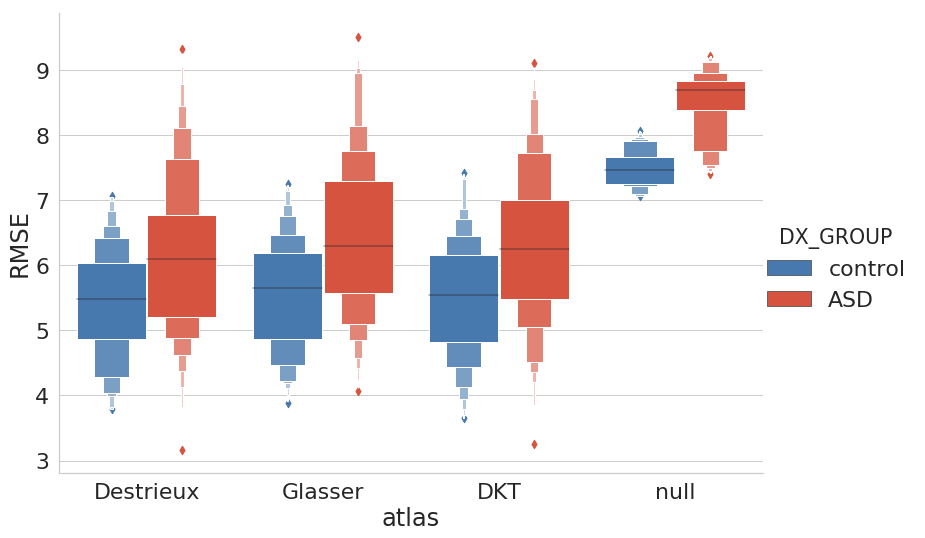

In [40]:
print(perf_pval_dict)
plot_df = ml_perf_concat.copy()
x_order = ['Destrieux','Glasser','DK','null']
col_order = ['No_QC','manual_maarten','manual_gleb','auto']

#colors = ["windows blue", "tomato", "greyish", "dark grey","faded green", "dusty purple"]
palette = sns.xkcd_palette(colors) #'Paired' #sns.xkcd_palette(colors)


sns.set(font_scale=5)

plot_df['atlas'] = plot_df['atlas'].replace({'aparc':'DK'})
plot_df = plot_df[plot_df['qc']=='No_QC']

if model_type.lower() == 'regression':
    plot_df['RMSE'] = np.sqrt(-1*plot_df['neg_mean_squared_error'])
    plot_df['DX_GROUP'] = plot_df['DX_GROUP'].replace({0:'control', 1:'ASD'})
    #plot_df['qc'] = plot_df['qc'].replace({'manual_maarten':'Manual', 'auto':'Auto/Outlier'})
    sns.set(font_scale=2)
    with sns.axes_style("whitegrid"): 
        
        g = sns.catplot(y='RMSE',x='atlas',kind='boxen',hue='DX_GROUP', #col='qc',col_order=col_order,col_wrap=2, 
                        data=plot_df, legend=True,
                        order=x_order, palette=palette, height=8, aspect=1.4 )
        #plt.legend(loc='upper right')
else:
    with sns.axes_style("white"): 
        g = sns.catplot(y='roc_auc',x='atlas', kind='boxen',data=plot_df,col='qc',col_order=col_order,
                        order=x_order,palette=palette,height=20, aspect=1.1,legend=False)    

### Get ML based feature importance

In [52]:
# save_path = '{}atlas_ml_feature_imp_{}_{}.pkl'.format(ml_results_dir,outcome_col,model_type)
# feature_rank_df_concat = pd.read_pickle(save_path)

feature_count_df = pd.DataFrame(columns=['count','atlas','DX_GROUP','qc'])
i = 0
for atlas in data_dict.keys():
    master_df_raw = pd.merge(useful_demograph,data_dict[atlas],on= subject_ID_col)
    roi_cols = list(master_df_raw.filter(regex='^L|R_', axis=1).columns)
    for qc in feature_rank_df_concat['qc'].unique():
        for dx in [0,1]:
            n_feat = len(feature_rank_df_concat[(feature_rank_df_concat['rank'] == 1) &                              
                                                (feature_rank_df_concat['atlas'] == atlas) &                              
                                                (feature_rank_df_concat['predictor'].isin(roi_cols)) & 
                                                (feature_rank_df_concat['qc'] == qc) &
                                                (feature_rank_df_concat['DX_GROUP'] == dx)])
            feature_count_df.loc[i] = [n_feat,atlas,dx,qc]
            i+=1
            print('atlas {}, n_roi {}, qc {}, dx {}, n_feat {}\n'.format(atlas,len(roi_cols),qc,dx,n_feat))

atlas Glasser, n_roi 360, qc No_QC, dx 0, n_feat 30

atlas Glasser, n_roi 360, qc No_QC, dx 1, n_feat 22

atlas Glasser, n_roi 360, qc manual_maarten, dx 0, n_feat 41

atlas Glasser, n_roi 360, qc manual_maarten, dx 1, n_feat 42

atlas Glasser, n_roi 360, qc manual_gleb, dx 0, n_feat 248

atlas Glasser, n_roi 360, qc manual_gleb, dx 1, n_feat 294

atlas Glasser, n_roi 360, qc auto, dx 0, n_feat 23

atlas Glasser, n_roi 360, qc auto, dx 1, n_feat 21

atlas aparc, n_roi 68, qc No_QC, dx 0, n_feat 18

atlas aparc, n_roi 68, qc No_QC, dx 1, n_feat 65

atlas aparc, n_roi 68, qc manual_maarten, dx 0, n_feat 57

atlas aparc, n_roi 68, qc manual_maarten, dx 1, n_feat 35

atlas aparc, n_roi 68, qc manual_gleb, dx 0, n_feat 27

atlas aparc, n_roi 68, qc manual_gleb, dx 1, n_feat 25

atlas aparc, n_roi 68, qc auto, dx 0, n_feat 26

atlas aparc, n_roi 68, qc auto, dx 1, n_feat 19

atlas Destrieux, n_roi 148, qc No_QC, dx 0, n_feat 19

atlas Destrieux, n_roi 148, qc No_QC, dx 1, n_feat 22

atlas De

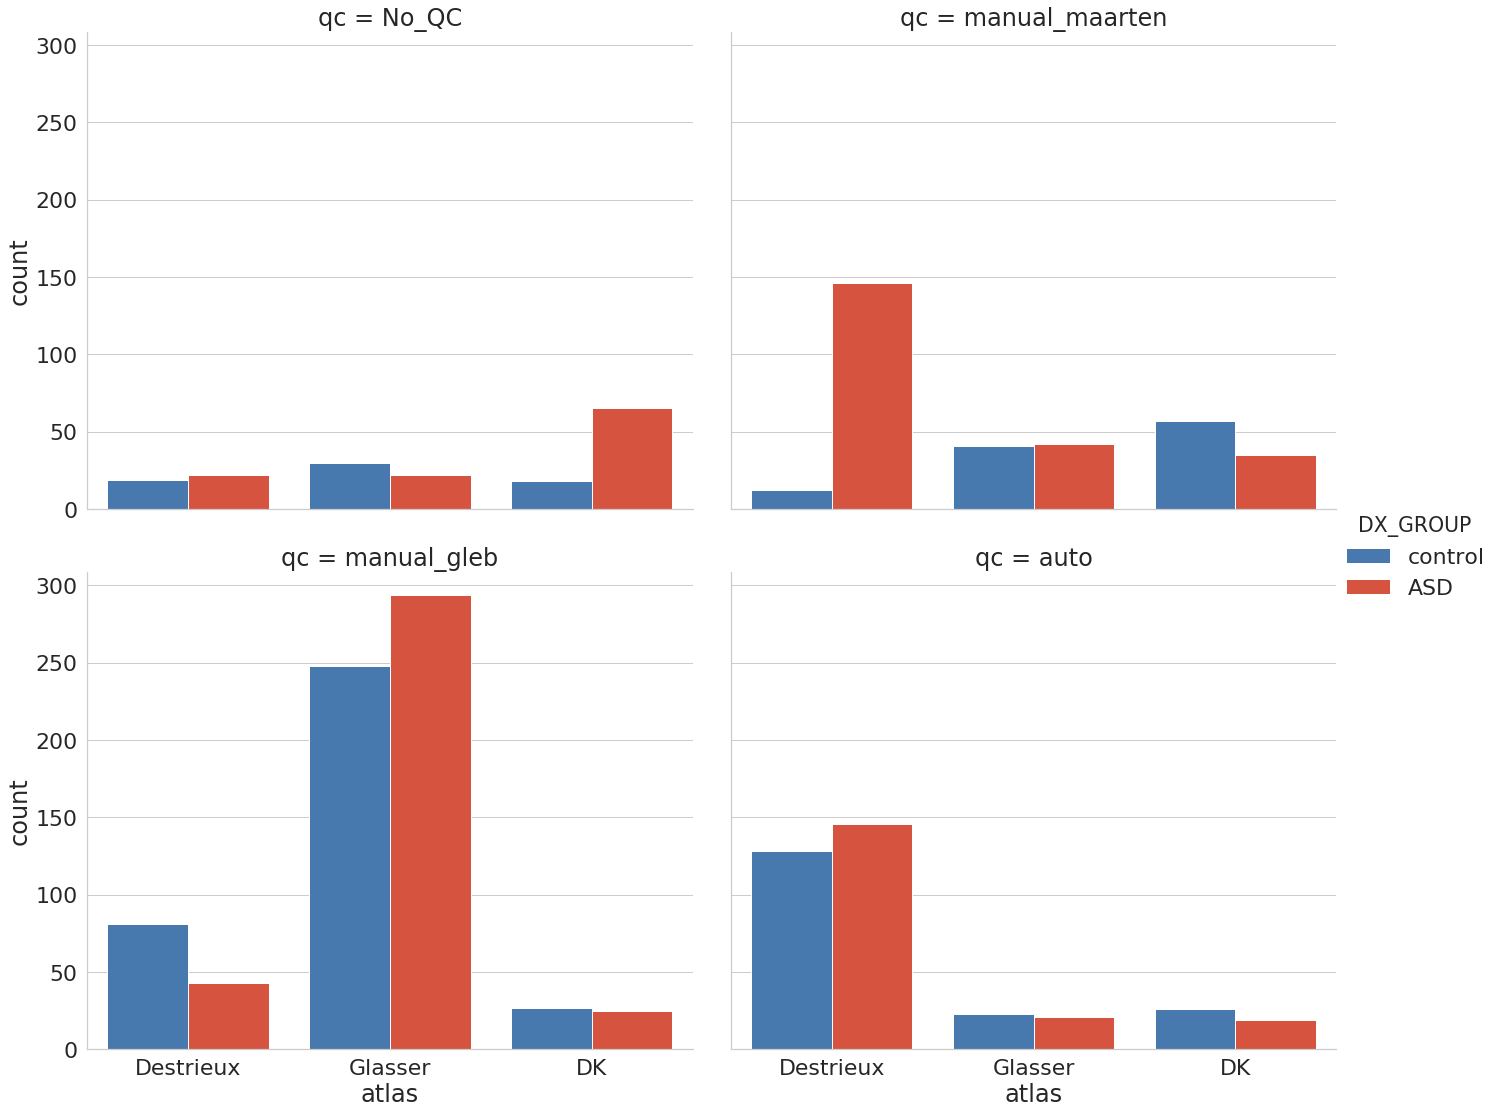

In [55]:
plot_df = feature_count_df #[feature_count_df['qc']=='No_QC']
plot_df['atlas'] = plot_df['atlas'].replace({'aparc':'DK'})
plot_df['DX_GROUP'] = plot_df['DX_GROUP'].replace({0:'control', 1:'ASD'})
sns.set(font_scale=2)

with sns.axes_style("whitegrid"): 
    x_order = ['Destrieux','Glasser','DK']
    g = sns.catplot(y='count',x='atlas',hue='DX_GROUP', col='qc', col_wrap=2,
                    kind='bar', palette=palette, height=8, aspect=1.2, data=plot_df, order=x_order)


### Compare statsmodels performance 

In [6]:
ml_results_dir = results_dir + 'sm/'
model_type = 'ols'
if model_type == 'ols':
    covar_cols = [('DX_GROUP','cat'),('SEX','cat'),('SITE_ID','cat')]
    outcome_col = ('AGE_AT_SCAN','continuous')
    signific_col = ('roi','continuous')
    stat_model = 'ols' 
elif model_type == 'logit':
    covar_cols = [('AGE_AT_SCAN','continuous'),('SEX','cat'),('SITE_ID','cat')]
    outcome_col = ('DX_GROUP','cat') 
    signific_col = ('roi','continuous') 
    stat_model = 'logit' 
else:
    print('unknown stat model')
    
save_sm_perf = True
n_workflow = 1 #Analyzing each atlas separately
qc_list = ['No_QC','manual_maarten','manual_gleb','auto']

outlier_df = pd.DataFrame(index=useful_demograph[subject_ID_col].unique())
for qc in qc_list:
    # For each atlas create a dictionary df
    stat_perf_dict = {}
    for atlas in data_dict.keys():
        start_time_atlas = time.time()
        print('\nAtlas {}'.format(atlas))
        
        mr_data_df = data_dict[atlas]
        roi_cols = list(mr_data_df.filter(regex='^L|R_', axis=1).columns)
        master_df_raw = pd.merge(useful_demograph,mr_data_df[[subject_ID_col]+ roi_cols],on=subject_ID_col)

        if qc == 'No_QC':
            print('No QC applied')
            filtered_df = master_df_raw
            filtered_subs = filtered_df[subject_ID_col].unique()
            print('Resultant number of subjects {}'.format(len(filtered_subs)))
        else:            
            if qc == 'manual_maarten':
                qc_df = pd.read_csv(qc_dir + 'master_QC_table.csv',dtype={'SubjID': int})
                qc_criterion = ('QC_maarten',[0]) # keep subs
            elif qc == 'manual_gleb':
                qc_df = pd.read_csv(qc_dir + 'master_QC_table.csv',dtype={'SubjID': int})
                qc_criterion = ('QC_gleb',['1','-+1']) # keep subs
            elif qc == 'auto':
                outlier_file = outlier_file_dict[atlas]
                qc_df = pd.read_csv(outlier_dir + outlier_file,dtype={'SubjID': int})
                qc_criterion = ('outlier_all_data',[0])    
            else:
                print('Unknow QC type')

            # Subjects you want to keep based on other crieria for sample size purposes
            external_criterion = {'SITE_ID':4*n_workflow}
            filtered_df = filter_data(master_df_raw, subject_ID_col, qc_df, qc_criterion, external_criterion)
            filtered_subs = filtered_df[subject_ID_col].unique()

        master_df = filtered_df
        master_df['atlas'] = np.tile(atlas,len(master_df))
        sm_perf = getStatModelPerf(master_df,roi_cols,covar_cols,outcome_col,signific_col,stat_model)
        
        print('Shape of the stats_models results df {}'.format(sm_perf.shape))
        print('Top 5 significant regions:\n {}'.format(sm_perf.sort_values(by=['p_val']).head(5)))
        print('')
        stat_perf_dict[atlas] = sm_perf
        
    #only need to do it for one atlas (since manual outliers are same for all atlases)
    if qc != 'No_QC':
        outlier_df[qc] = np.where(outlier_df.index.isin(filtered_subs),0,1)
        
    if save_sm_perf:
        save_path = '{}atlas_sm_perf_{}_{}_{}_QC_{}_N_{}.pkl'.format(results_dir,outcome_col[0],signific_col[0],stat_model,qc,len(filtered_subs))
        print('Saving sm_perf dictionary at \n{}'.format(save_path))
        with open(save_path, 'wb') as handle:
            pickle.dump(stat_perf_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)



Atlas Glasser
No QC applied
Resultant number of subjects 1047
Example statsmodel run:
 AGE_AT_SCAN ~ R_p24_ROI + C(DX_GROUP) + C(SEX) + C(SITE_ID)
Shape of the stats_models results df (360, 5)
Top 5 significant regions:
              roi       coef      t_val         p_val    p_val_corr
85   L_9_46d_ROI -12.845638 -14.914429  1.144941e-45  4.121789e-43
216    R_5mv_ROI -11.335491 -14.500428  1.786106e-43  3.214990e-41
36     L_5mv_ROI -10.697308 -14.381826  7.461315e-43  8.953578e-41
265  R_9_46d_ROI -11.233330 -13.866588  3.396148e-40  2.908794e-38
217    R_23c_ROI -12.993364 -13.851788  4.039991e-40  2.908794e-38


Atlas aparc
No QC applied
Resultant number of subjects 1047
Example statsmodel run:
 AGE_AT_SCAN ~ R_insula + C(DX_GROUP) + C(SEX) + C(SITE_ID)
Shape of the stats_models results df (68, 5)
Top 5 significant regions:
                    roi       coef      t_val         p_val    p_val_corr
57         R_precuneus -21.263405 -20.458913  2.885842e-78  1.962372e-76
23         

Example statsmodel run:
 AGE_AT_SCAN ~ R_p24_ROI + C(DX_GROUP) + C(SEX) + C(SITE_ID)
Shape of the stats_models results df (360, 5)
Top 5 significant regions:
              roi       coef      t_val         p_val    p_val_corr
85   L_9_46d_ROI -10.097128 -15.886074  1.680136e-50  6.048489e-48
216    R_5mv_ROI  -8.820383 -15.134258  1.867330e-46  3.361193e-44
36     L_5mv_ROI  -8.392426 -15.087377  3.308783e-46  3.970540e-44
145    L_IP0_ROI  -9.107227 -14.611590  1.034096e-43  9.306863e-42
231      R_2_ROI  -9.611945 -14.504266  3.719860e-43  2.678299e-41


Atlas aparc

Filtering based on outlier_all_data. Number subjects before filtering 1047
Resultant number of subjects 961
Filtering based on external crierion
Performing min sample (N_min=4) per workflow size check based on SITE_ID
Dropping subjects for all workflows for SITE_ID SBL    3
Name: SITE_ID, dtype: int64
Resultant number of subjects 958
Example statsmodel run:
 AGE_AT_SCAN ~ R_insula + C(DX_GROUP) + C(SEX) + C(SITE_ID)
Shap

Total number of subjects: 1112

outlier overlap
                manual_maarten  manual_gleb  auto
manual_maarten             137          135    72
manual_gleb                135          887   147
auto                        72          147   154


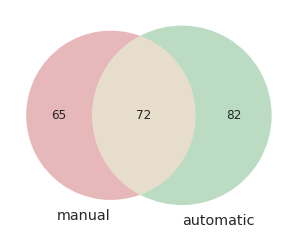

In [76]:
# Outlier comparisons
outlier_overlap = outlier_df.T.dot(outlier_df)
print('Total number of subjects: {}\n'.format(len(outlier_df)))
print('outlier overlap')
print(outlier_overlap)

# Venn diagrams
s1 = set(outlier_df[outlier_df['manual_maarten']==1].index)
s2 = set(outlier_df[outlier_df['manual_gleb']==1].index)
s3 = set(outlier_df[outlier_df['auto']==1].index)
v = venn2([s1,s3],set_labels = ('manual', 'automatic'))
#venn3([s1,s2,s3],set_labels = ('manual_maarten', 'manual_gleb', 'auto'))


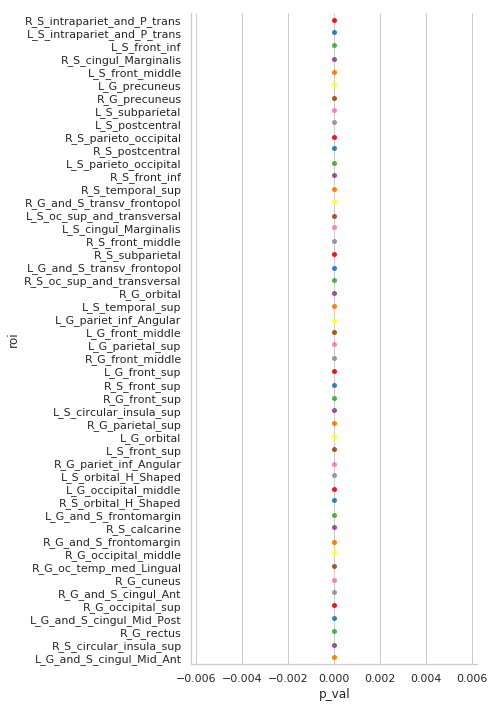

In [10]:
# Plots
aparc = 'Destrieux' #'Destrieux', 'aparc','Glasser'
top_rois = 50
plot_df = stat_perf_dict[aparc].sort_values(by=['p_val']).head(top_rois)

sns.set(font_scale=1)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x='p_val',y='roi',kind='strip',
                    data=plot_df,palette='Set1',height=10,aspect=0.7)
    #g.set(xscale="log");